In [1]:
%reload_ext autoreload
%autoreload 2
import numpy as np
import pandas as pd
import tensorflow as tf
from keras import (
    Input,
    Sequential,
    layers,
    callbacks,
    optimizers,
)
from conlanger.models.WGANGP import WGANGP
from conlanger.utils import display_rows, get_closest_matches, get_exact_matches_indices
from IPython.display import display



2024-09-18 19:15:17.360470: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-09-18 19:15:17.542992: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-18 19:15:17.609511: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-09-18 19:15:17.628373: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-09-18 19:15:17.754593: I tensorflow/core/platform/cpu_feature_guar

In [2]:
USE_GPU = True
TRAIN = False

In [3]:
tf.test.gpu_device_name()

if USE_GPU:
    with tf.device('/gpu:0'):
        gpu = tf.config.list_physical_devices("GPU")
        if not gpu:
            raise

I0000 00:00:1726683319.810420    4272 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1726683319.955699    4272 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1726683319.957179    4272 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1726683320.066586    4272 cuda_executor.cc:1015] successful NUMA node read from SysFS ha

In [4]:
IMAGE_SIZE = 14
CHANNELS = 1
BATCH_SIZE = 512
Z_DIM = IMAGE_SIZE * IMAGE_SIZE
CRITIC_LEARNING_RATE = 0.0002
GENERATOR_LEARNING_RATE = 0.0008
EPOCHS = 600
CRITIC_STEPS = 5
GP_WEIGHT = 10.0
LOAD_MODEL = False
ADAM_BETA_1 = 0.5
ADAM_BETA_2 = 0.9
NUM_LANGS = 100
STEPS_PER_EPOCH = 3
REPEAT_DATA = 30

In [5]:
data = np.load("./data/language_parameters.npz", allow_pickle=True)
language_parameters = data["language_parameters"]
languages = data["languages"]
parameters = data["parameters"]

l = language_parameters.shape[0]

X = np.hstack([language_parameters.copy(), np.zeros((l, 8))]).reshape(l, IMAGE_SIZE, IMAGE_SIZE)
X = np.expand_dims(X, axis=3)

MAX_VALUE = X.max()

X /= MAX_VALUE

assert language_parameters.shape[0] == languages.shape[0]

language_parameters.shape, languages.shape, parameters.shape, X.shape, Z_DIM

((852, 188), (852, 2), (188, 2), (852, 14, 14, 1), 196)

In [6]:
critic = Sequential(
    [
        Input(shape=X.shape[1:]),
        layers.Conv2D(IMAGE_SIZE, kernel_size=3, strides=2, padding="same"),
        layers.LeakyReLU(0.2),
        layers.Conv2D(IMAGE_SIZE * 2, kernel_size=3, strides=2, padding="same"),
        layers.LeakyReLU(),
        layers.Dropout(0.3),
        layers.Conv2D(IMAGE_SIZE * 4, kernel_size=3, strides=2, padding="same"),
        layers.LeakyReLU(0.2),
        layers.Dropout(0.3),
        layers.Conv2D(IMAGE_SIZE * 8, kernel_size=3, strides=2, padding="same"),
        layers.LeakyReLU(0.2),
        layers.Dropout(0.3),
        layers.Conv2D(IMAGE_SIZE * IMAGE_SIZE, kernel_size=2, strides=1, padding="same"),
        layers.LeakyReLU(0.2),
        layers.Dropout(0.3),
        layers.Flatten(),
    ],
    name="critic",
)
critic.summary()

Model: "critic"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 7, 7, 14)       │           140 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu (LeakyReLU)         │ (None, 7, 7, 14)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 4, 4, 28)       │         3,556 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_1 (LeakyReLU)       │ (None, 4, 4, 28)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 4, 4, 28)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 2, 2, 56)       │        14,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_2 (LeakyReLU)       │ (None, 2, 2, 56)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 2, 2, 56)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 1, 1, 112)      │        56,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_3 (LeakyReLU)       │ (None, 1, 1, 112)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 1, 1, 112)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 1, 1, 196)      │        88,004 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_4 (LeakyReLU)       │ (None, 1, 1, 196)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 1, 1, 196)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 196)            │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 162,428 (634.48 KB)

 Trainable params: 162,428 (634.48 KB)

 Non-trainable params: 0 (0.00 B)

In [7]:
generator = Sequential(
    [
        Input(shape=(Z_DIM,)),
        layers.Reshape((1, 1, Z_DIM)),
        layers.Conv2DTranspose(
            IMAGE_SIZE * IMAGE_SIZE, kernel_size=4, strides=2, padding="valid", use_bias=False
        ),
        layers.Dropout(0.3),
        layers.Conv2D(
            IMAGE_SIZE * 8, kernel_size=4, strides=2, padding="same", use_bias=False
        ),
        layers.BatchNormalization(momentum=0.9),
        layers.LeakyReLU(0.2),
        layers.Dropout(0.3),
        layers.Conv2D(
            IMAGE_SIZE * 4, kernel_size=4, strides=2, padding="same", use_bias=False
        ),
        layers.BatchNormalization(momentum=0.9),
        layers.LeakyReLU(0.2),
        layers.Conv2DTranspose(
            IMAGE_SIZE * 2, kernel_size=4, strides=2, padding="same", use_bias=False
        ),
        layers.LeakyReLU(0.2),
        layers.Conv2DTranspose(
            IMAGE_SIZE * 2, kernel_size=2, strides=2, padding="same", use_bias=False
        ),
        layers.Dropout(0.3),
        layers.Conv2D(IMAGE_SIZE * 2, kernel_size=2, strides=2, padding="same", use_bias=False),
        layers.BatchNormalization(momentum=0.9),
        layers.LeakyReLU(0.2),
        layers.Conv2DTranspose(
            IMAGE_SIZE * 2, kernel_size=2, strides=2, padding="same", use_bias=False
        ),
        layers.Dropout(0.3),
        layers.Conv2D(IMAGE_SIZE * 4, kernel_size=2, strides=4, padding="same", use_bias=False),
        layers.BatchNormalization(momentum=0.9),
        layers.LeakyReLU(0.2),
        layers.Conv2DTranspose(
            IMAGE_SIZE * IMAGE_SIZE, kernel_size=8, strides=1, padding="same", activation="sigmoid"
        ),
        layers.Reshape(X.shape[1:]),
    ],
    name="generator",
)
generator.summary()

Model: "generator"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ reshape (Reshape)               │ (None, 1, 1, 196)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose                │ (None, 4, 4, 196)      │       614,656 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 4, 4, 196)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 2, 2, 112)      │       351,232 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 2, 2, 112)      │           448 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_5 (LeakyReLU)       │ (None, 2, 2, 112)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 2, 2, 112)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 1, 1, 56)       │       100,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 1, 1, 56)       │           224 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_6 (LeakyReLU)       │ (None, 1, 1, 56)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_1              │ (None, 2, 2, 28)       │        25,088 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_7 (LeakyReLU)       │ (None, 2, 2, 28)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_2              │ (None, 4, 4, 28)       │         3,136 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 4, 4, 28)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 2, 2, 28)       │         3,136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 2, 2, 28)       │           112 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_8 (LeakyReLU)       │ (None, 2, 2, 28)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_3              │ (None, 4, 4, 28)       │         3,136 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 4, 4, 28)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 1, 1, 56)       │         6,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 1, 1, 56)       │           224 │
│ (BatchNormalization)            │                        │             

 Total params: 1,810,676 (6.91 MB)

 Trainable params: 1,810,172 (6.91 MB)

 Non-trainable params: 504 (1.97 KB)

In [8]:
# Create a GAN
wgangp = WGANGP(
    critic=critic,
    generator=generator,
    latent_dim=Z_DIM,
    critic_steps=CRITIC_STEPS,
    gp_weight=GP_WEIGHT,
)

In [9]:
# Compile the GAN
wgangp.compile(
    c_optimizer=optimizers.Adam(
        learning_rate=CRITIC_LEARNING_RATE, beta_1=ADAM_BETA_1, beta_2=ADAM_BETA_2
    ),
    g_optimizer=optimizers.Adam(
        learning_rate=GENERATOR_LEARNING_RATE, beta_1=ADAM_BETA_1, beta_2=ADAM_BETA_2
    ),
)

In [10]:
import matplotlib.pyplot as plt


class ImageGenerator(callbacks.Callback):
    def __init__(self, latent_dim, num_img=10, display_on_epoch=10, figsize=(28, 28)):
        self.num_img = num_img
        self.latent_dim = latent_dim
        self.display_on_epoch = display_on_epoch
        self.figsize = figsize

    def on_epoch_end(self, epoch, logs=None):
        if epoch % self.display_on_epoch == 0:
            random_latent_vectors = tf.random.normal(
                shape=(self.num_img, self.latent_dim)
            )
            generated_images = self.model.generator(random_latent_vectors).numpy()
            plt.figure(figsize=self.figsize)

            for i in range(self.num_img):
                _ = plt.subplot(1, self.num_img, i + 1)
                plt.imshow(generated_images[i].astype("float32"), cmap="copper_r")
                plt.axis("off")
            
            plt.show()

In [11]:
if TRAIN:
    dataset = tf.data.Dataset.from_tensors(X.astype("float32")).repeat(REPEAT_DATA)

    wgangp.fit(
        dataset,
        epochs=EPOCHS,
        steps_per_epoch=STEPS_PER_EPOCH,
        callbacks=[
            ImageGenerator(latent_dim=Z_DIM),
        ],
    )

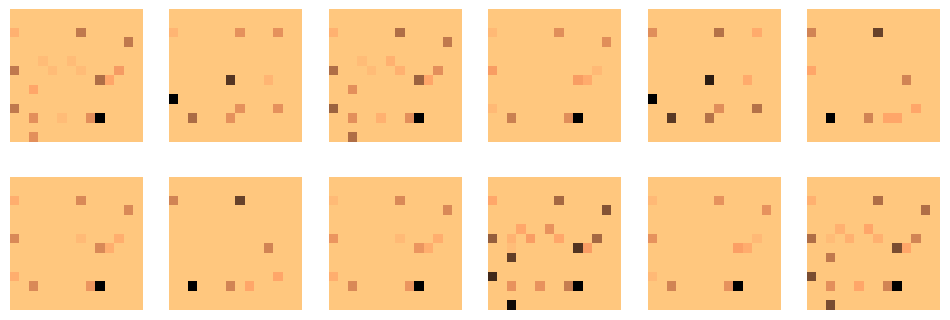

(100, 14, 14, 1)

In [12]:
if TRAIN:
    
    noise = np.random.normal(size=(NUM_LANGS, Z_DIM))
    generated_language_parameters = wgangp.generator.predict(noise)
    l = generated_language_parameters.shape[0]

    # normalise
    generated_language_parameters = (generated_language_parameters-np.min(generated_language_parameters))/(np.max(generated_language_parameters)-np.min(generated_language_parameters))

    # weirdness
    mean_lang = np.mean(X, axis=0).reshape(-1)
    diff_from_mean = np.array([np.mean(np.abs(mean_lang - g)) for g in generated_language_parameters])
    weirdness = np.round((diff_from_mean-np.min(diff_from_mean))/(np.max(diff_from_mean)-np.min(diff_from_mean)), decimals=2)

    np.savez_compressed(
        "./data/generated_language_parameters.npz",
        generated_language_parameters=generated_language_parameters,
        weirdness=weirdness
    )

else:
    data = np.load("./data/generated_language_parameters.npz", allow_pickle=True)
    generated_language_parameters = data["generated_language_parameters"]
    weirdness = data["weirdness"]
    l = generated_language_parameters.shape[0]

generated = (generated_language_parameters * MAX_VALUE).astype(int)

display_rows(generated, cmap="copper_r", r=2, c=6, size=(12, 4))

generated.shape

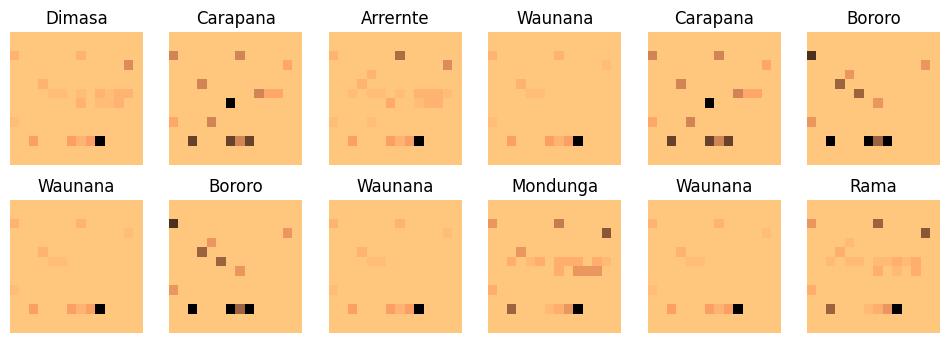

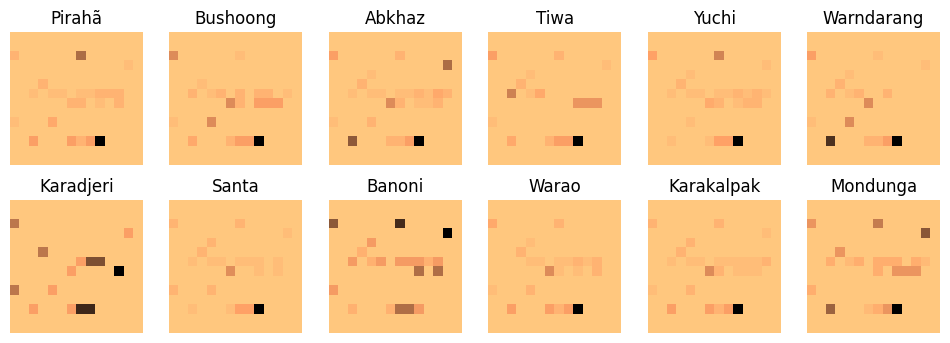

(0.12755102040816327, 0.23581632653061224, 0.8520408163265306)

In [13]:
# find closest matches
origin = (X * MAX_VALUE).astype(int)

closest_idx, closest, closest_diff = get_closest_matches(origin, generated, n=NUM_LANGS)
closest_language_names = np.take(languages[:, 1], closest_idx)

display_rows(closest, titles=closest_language_names, cmap="copper_r", r=2, c=6, size=(12, 4))

# random samples
gen = np.random.default_rng()
sample_indices = gen.choice(origin.shape[0], 12, replace=False)
samples = origin[sample_indices]
sample_names = languages[:, 1][sample_indices]

display_rows(samples, titles=sample_names, cmap="copper_r", r=2, c=6, size=(12, 4))

np.min(closest_diff), np.mean(closest_diff), np.max(closest_diff)

In [14]:
# find exact matches

exact_idx = get_exact_matches_indices(origin, generated)
exact = np.take(X, exact_idx)
exact_language_names = np.take(languages[:, 1], exact_idx)

if len(exact_idx) > 0:
    display_rows(exact, titles=exact_language_names, cmap="copper_r", r=3, c=6, size=(12, 6))
else:
    print("No exact matches. Noice!")

origin.shape, exact_idx.shape

No exact matches. Noice!


((852, 14, 14, 1), (0,))

In [75]:
generated_parameters = generated.reshape(generated.shape[0], -1, 1)[:, 0:parameters.shape[0]]

generated_parameters = np.array([np.hstack([parameters[:, 0:1], gp]) for gp in generated_parameters])

generated_parameters.shape, parameters.shape, parameters[0]

((100, 188, 2), (188, 2), array(['1A', 'Consonant Inventories'], dtype=object))

In [16]:
from cldfbench import get_dataset

wals = get_dataset("wals").cldf_reader()

param_df = (
    pd.DataFrame(wals.iter_rows("ParameterTable"))
    .set_index(["Area", "Chapter"])
    .drop(columns=["Description", "Contributor_ID"])
)

param_df = param_df[
    ~param_df.index.get_level_values("Area").isin(["Sign Languages", "Other"])
]

param_df.head(5)

ID  \
Area      Chapter                                   
Phonology Consonant Inventories                1A   
          Vowel Quality Inventories            2A   
          Consonant-Vowel Ratio                3A   
          Voicing in Plosives and Fricatives   4A   
          Voicing and Gaps in Plosive Systems  5A   

                                                                              Name  
Area      Chapter                                                                   
Phonology Consonant Inventories                              Consonant Inventories  
          Vowel Quality Inventories                      Vowel Quality Inventories  
          Consonant-Vowel Ratio                              Consonant-Vowel Ratio  
          Voicing in Plosives and Fricatives    Voicing in Plosives and Fricatives  
          Voicing and Gaps in Plosive Systems  Voicing and Gaps in Plosive Systems